# Competition: [Regression with a Mohs Hardness Dataset](https://www.kaggle.com/competitions/playground-series-s3e25)

**Keywords**: #Regression #Playground #FeedforwardNeuralNetwork #FNN

## Introduction

In this project, our objective is to develop a robust predictive model for estimating the Mohs hardness of minerals based on their intrinsic properties. **Mohs hardness, a measure of a mineral's resistance to scratching,** is a crucial factor in various industrial applications, material science, and geology. Accurate prediction of Mohs hardness can expedite mineral classification and aid in material selection for specific purposes.

Motivated by the need for efficient and accurate mineral hardness prediction, we are leveraging advanced machine learning techniques, specifically TensorFlow/Keras neural networks. The project involves the creation of a regression model capable of understanding complex relationships within a dataset comprising 13 distinct mineral properties. The primary metric for model evaluation is the Median Absolute Error (MAE), ensuring a robust assessment of predictive accuracy.

By addressing this challenge, we aim to contribute to the field of mineralogy and material science, facilitating more precise hardness predictions and supporting advancements in various industries reliant on mineral properties. The small dataset of 10,000 data points, coupled with the incorporation of data augmentation and rigorous model tuning, underscores our commitment to developing a reliable and efficient predictive tool.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2022/11/Mohs-Hardness-Scale.png?ssl=1")

## [Evaluation](www.kaggle.com/competitions/playground-series-s3e25/overview/evaluation)

Submissions are scored on the Median Absolute Error (MedAE). MedAE is defined as:

${\displaystyle \operatorname {MAD} =\operatorname {median} (|X_{i}-{\tilde {X}}|)}$

## [Data](https://www.kaggle.com/competitions/playground-series-s3e25/data)

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Prediction of Mohs Hardness with Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**

* **train.csv** - the training dataset; Hardness is the continuous target
* **test.csv** - the test dataset; your objective is to predict the value of Hardness
* **sample_submission.csv** - a sample submission file in the correct format

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import median_absolute_error

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.keras.utils.set_random_seed(42)

In [5]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

#df_train.info()
#df_train.tail().T

#df_train.isnull().sum()
#df_train.nunique()
#df_train.describe().T

In [6]:
def prepare_data(df, test=False):

    # Make the column names lower-case and uniform
    df.columns = df.columns.str.lower()

    # Drop id column
    df.drop('id', axis=1, inplace=True)
    
    # Logarithm transformation to reduce spread
    #log_cols = ['density_total','atomicweight_average']
    #df[log_cols] = np.log1p(df[log_cols])
    
    # remove zeros from dataframe
    if test == False:
        df = df[~(df.values == 0).any(axis=1)]
    
    return df

df_train = prepare_data(df_train)
df_test = prepare_data(df_test, test=True)

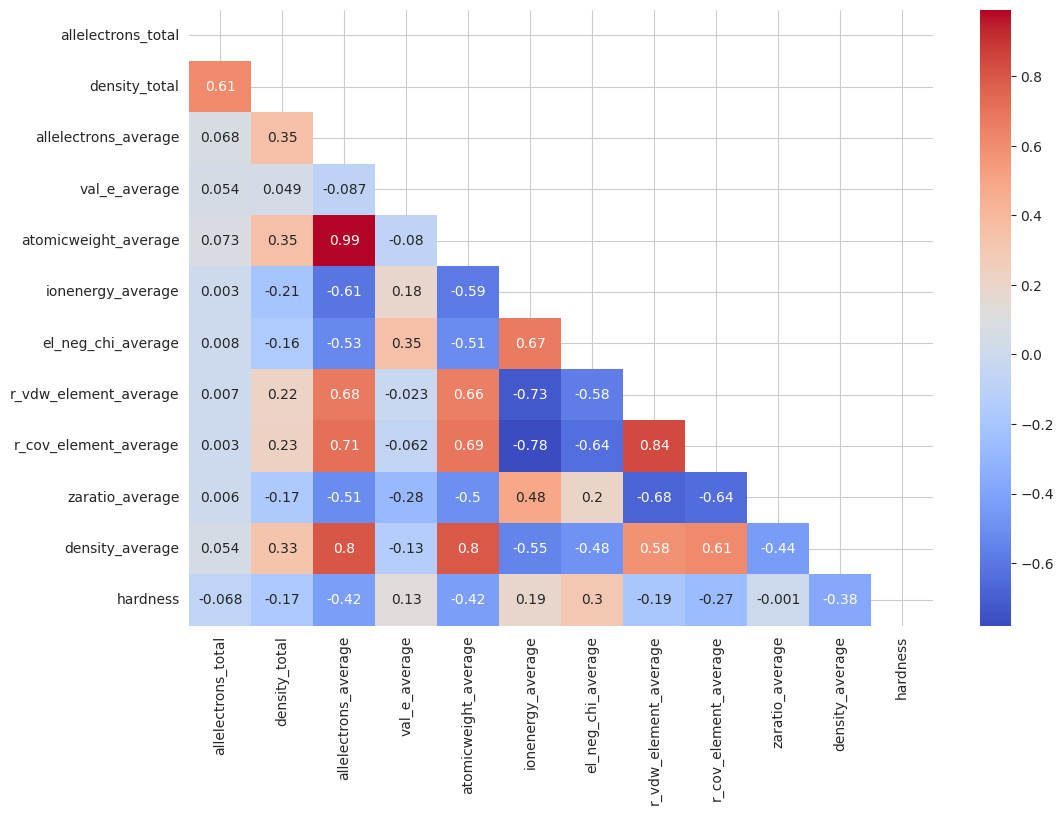

In [7]:
plt.figure(figsize=(12,8))
corr = df_train.corr().round(3)
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr))
plt.show()


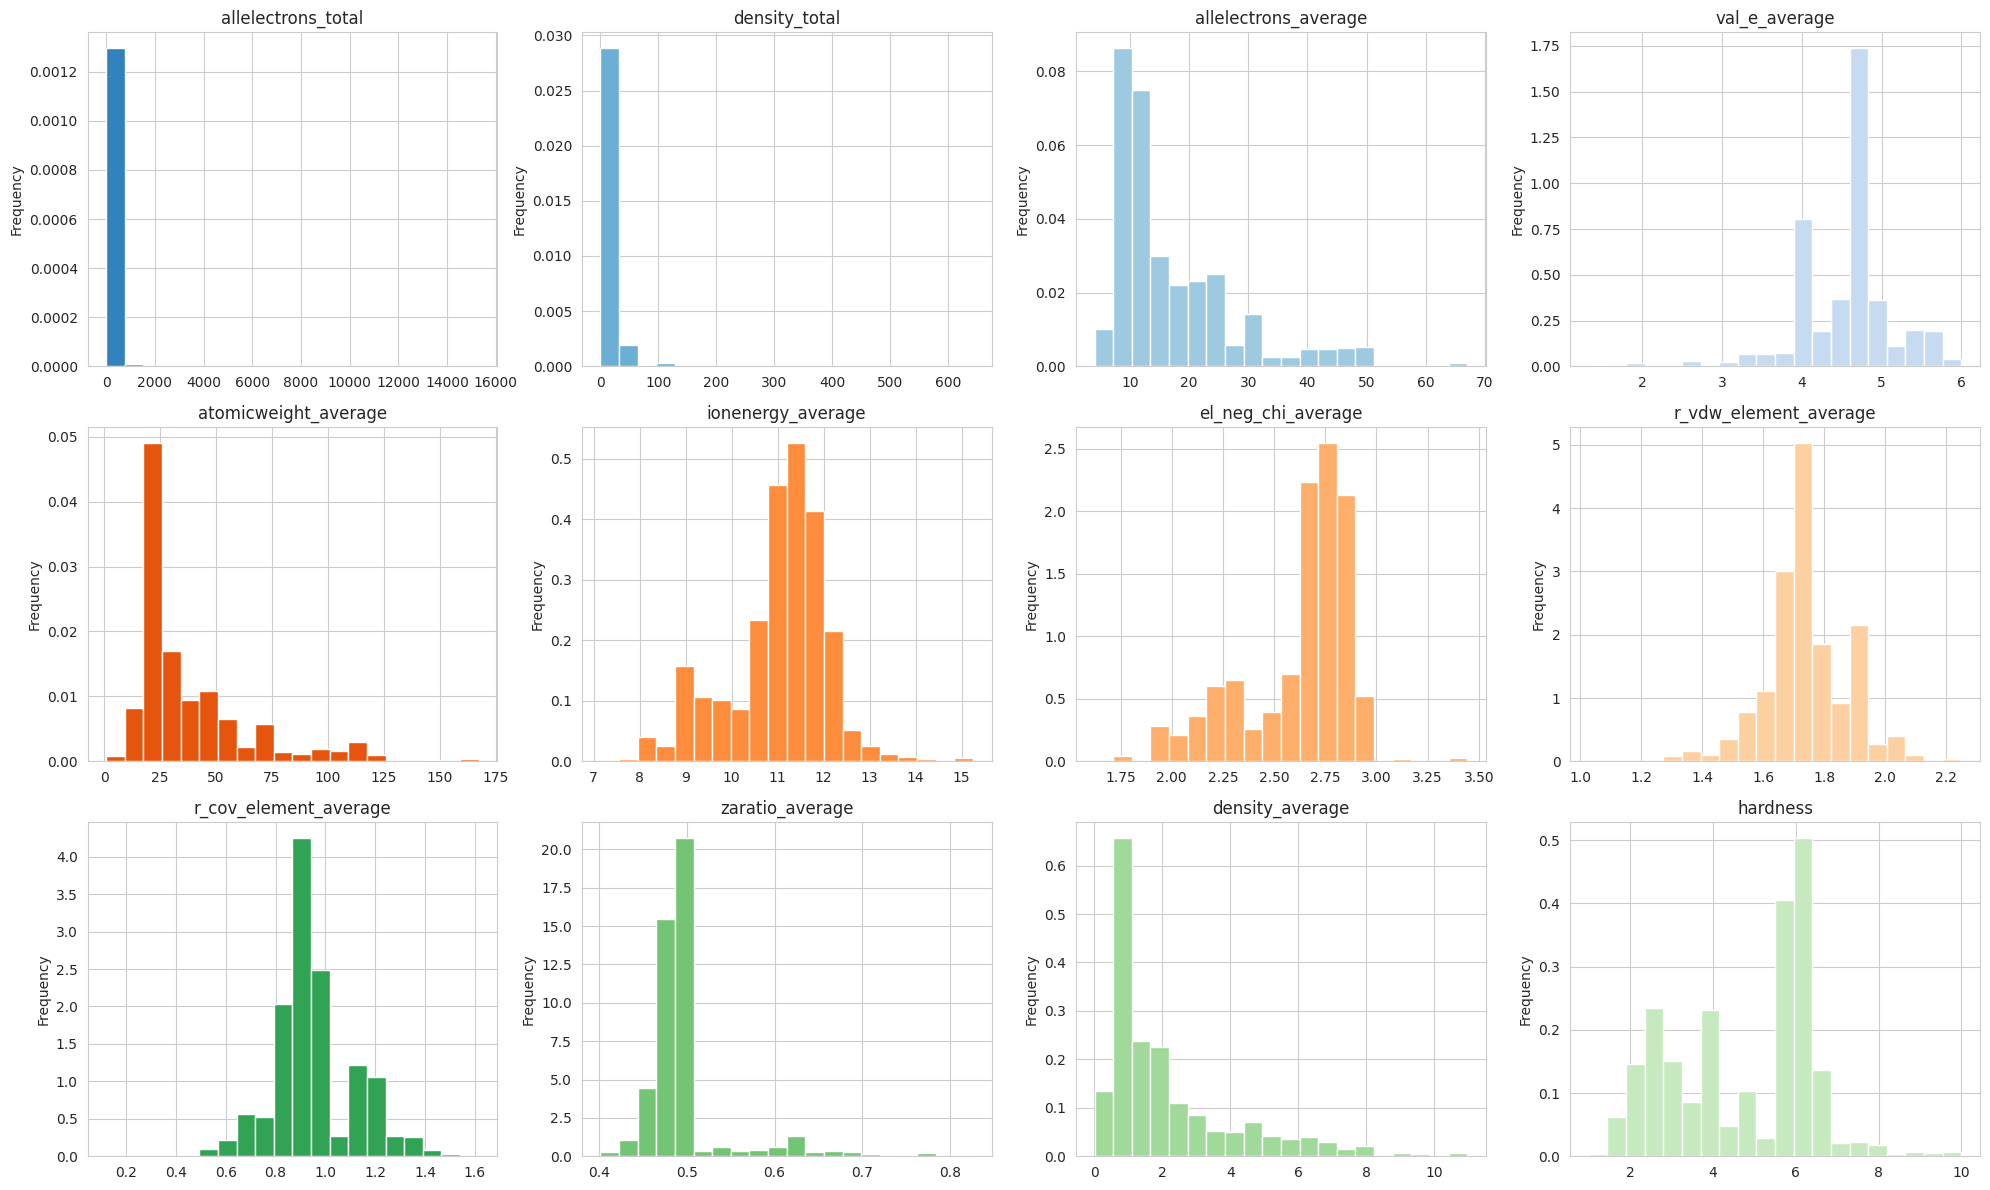

In [8]:
%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(df_train.columns.shape[0]))

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 12))
axs = axs.flatten()
    
for idx, col in enumerate(df_train.columns):
    df_train[col].plot.hist(ax=axs[idx], density=True, bins=20, color=colors[idx])
    axs[idx].set_title(col)
    
plt.tight_layout()

hardness                 1.000000
atomicweight_average     0.424739
allelectrons_average     0.424623
density_average          0.375443
el_neg_chi_average       0.303415
r_cov_element_average    0.266514
r_vdw_element_average    0.193044
ionenergy_average        0.187550
density_total            0.172590
val_e_average            0.130179
allelectrons_total       0.067533
zaratio_average          0.000869
dtype: float64

Text(0.5, 1.0, 'Correlation: Top 10 numerical features')

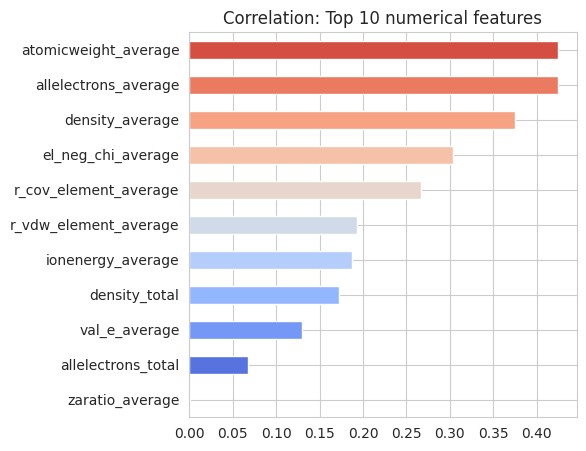

In [9]:
# Define the colormap
cmap = plt.get_cmap('coolwarm')

# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, len(df_train.columns))

# Get the corresponding colors from the colormap
colors = cmap(values)

corr = df_train.corrwith(df_train.hardness).abs().sort_values(ascending=False)
display(corr)

fig, ax = plt.subplots(figsize=(5,5))
corr[1:][::-1].plot.barh(ax=ax, cmap='tab20c', color=colors)
ax.set_title('Correlation: Top 10 numerical features')

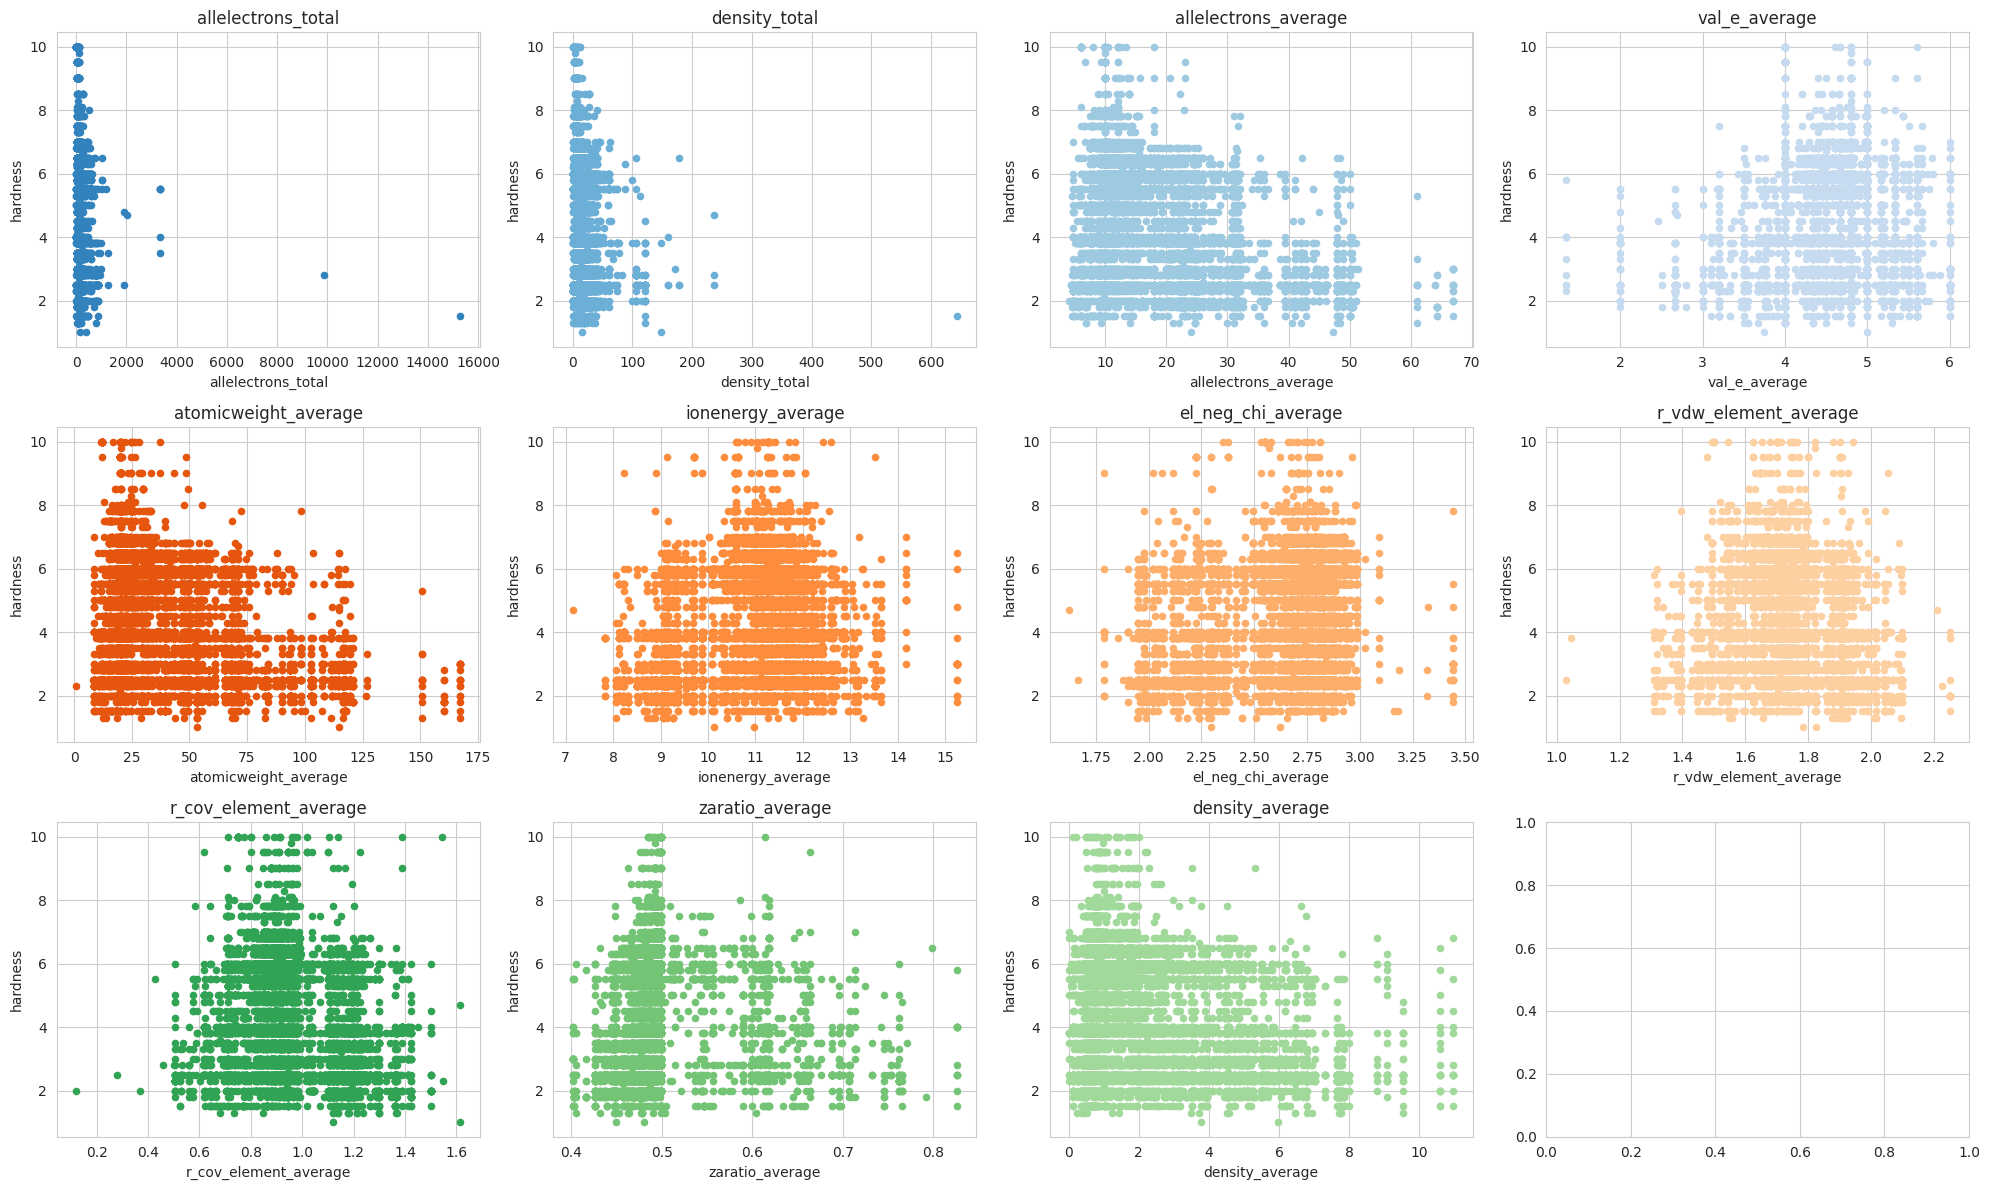

In [10]:
%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(df_train.columns[:-1].shape[0]))

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 12))
axs = axs.flatten()
    
for idx, col in enumerate(df_train.columns[:-1]):
    df_train[[col, 'hardness']].plot.scatter(x=col, y='hardness', ax=axs[idx], color=colors[idx])
    axs[idx].set_title(col)
    
plt.tight_layout()

In [11]:
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = np.log1p(df_train.hardness.values)
y_val = np.log1p(df_val.hardness.values)

del df_train['hardness']
del df_val['hardness']


In [12]:
# encoding
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_val = scaler.transform(df_val)
X_test = scaler.transform(df_test)

In [13]:
# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[-1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Custom Median Absolute Error metric
def medae_keras(y_true, y_pred):
    y_true = tf.math.expm1(y_true)
    y_pred = tf.round(tf.math.expm1(y_pred))
    absolute_errors = tf.abs(y_true - y_pred)
    medae = tfp.stats.percentile(absolute_errors, 50.0, interpolation='linear')
    return medae

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.MeanAbsoluteError()

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[medae_keras])

EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_medae_keras', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3, callbacks=[early_stopping], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping


In [14]:
def plot_metrics(history):
  metrics = ['loss', 'medae_keras']
  plt.figure(figsize=(10,5))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    plt.legend()     

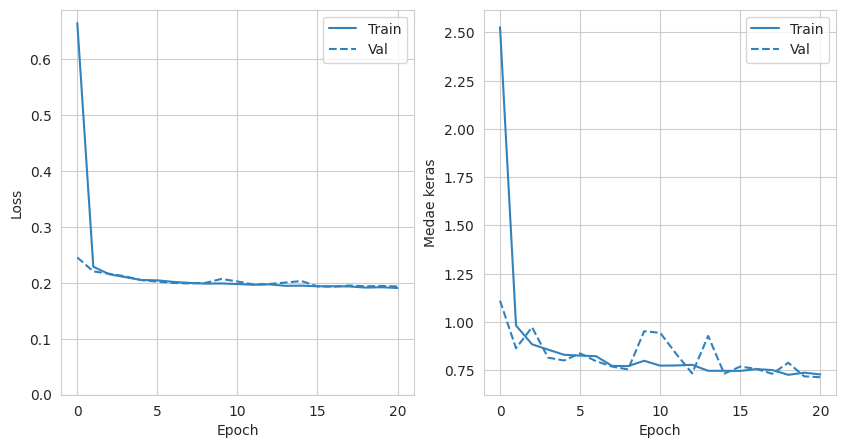

In [15]:
plot_metrics(history)


In [16]:
# Prediction
y_fit = np.expm1(model.predict(X_train, batch_size=BATCH_SIZE))
y_pred = np.expm1(model.predict(X_val, batch_size=BATCH_SIZE))

y_train = np.expm1(y_train)
y_val = np.expm1(y_val)

# Evaluation
print("Median Absolute Error (Training):", median_absolute_error(y_train, y_fit))
print("Median Absolute Error (Validation):", median_absolute_error(y_val, y_pred))

97/97 [==============================] - 0s 1ms/step
Median Absolute Error (Training): 1.1276731491088867
Median Absolute Error (Validation): 1.1234121322631836


In [17]:
submissions = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

y_submission = model.predict(X_test, batch_size=BATCH_SIZE)
y_submission = np.expm1(y_submission)
submissions['Hardness'] = y_submission.round(3)

submissions.to_csv('/kaggle/working/baseline.csv', index=False)

submissions.head()

217/217 [==============================] - 0s 1ms/step


,id,Hardness
0,10407,3.454
1,10408,5.591
2,10409,5.385
3,10410,4.928
4,10411,3.983
